AMATH 563 Homework 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import svd, eig
from numpy import transpose, matmul
from scipy.interpolate import interp1d
from scipy.linalg import hankel
from scipy.integrate import solve_ivp
from sklearn import linear_model

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def DMD(X1, X2, r, dt):
    """
    The DMD function computes the Dynamic Mode Decomposition of X1, X2

    Arguments:
         X1: X, data matrix(1)
         X2: X', shifted data matrix(2), Columns are state snapshots
    Returns:
        Phi: the DMD modes
        omega: the continues-time DMD eigenvalues
        lambda: the discrete-time DMD eigenvalues
        b: a vector of magnituedes of modes Phi
        Xdmd: data matrix recontructed by Phi, omega, b
    """
    # SVD the data matrix
    u,s,vh = svd(X1, full_matrices=False)
    r = min(r, u.shape[1])
    
    # truncate to rank-r
    u_r = u[:, :r]
    s_r = np.diag(s[:r])
    v_r = vh[:r, :]
    
    # Build Atilde and DMD Modes
    Atilde = np.linalg.solve(s_r.T,(u_r.T @ X2 @ v_r.T).T).T # Atilde = Ur'*X2*Vr/Sr
    w,v = eig(Atilde)
    Phi = X2 @ np.linalg.solve(s_r.T,v_r).T @ v
    
    # DMD Spectra
    Lambda = np.diag(w)
    omega = np.log(np.diag(Lambda))/dt
    
    # compute DMD mode amplitudes b
    alpha1 = s_r @ v_r[:,0]
    b = np.linalg.solve(v @ Lambda, alpha1)
    
    # DMD reconstruction
    mm1 = X1.shape[1]
    time_dynamics = np.zeros((r, mm1))
    t = [x*dt for x in range(mm1)]
    
    for iter in range(0, mm1):
        time_dynamics[:,iter] = np.diag(np.exp(omega*t[iter])) @ b.T
    
    Xdmd = Phi @ time_dynamics
    
    return Phi, Lambda, omega, b, Xdmd

In [4]:
def time_delayed_DMD(X1, X2, r, dt):
    """
    The DMD function computes the Dynamic Mode Decomposition of X1, X2

    Arguments:
         X1: X, data matrix(1)
         X2: X', shifted data matrix(2), Columns are state snapshots
    Returns:
        Phi: the DMD modes
        omega: the continues-time DMD eigenvalues
        lambda: the discrete-time DMD eigenvalues
        b: a vector of magnituedes of modes Phi
        Xdmd: data matrix recontructed by Phi, omega, b
    """
    # SVD the data matrix
    u,s,vh = svd(X1, full_matrices=False)
    r = min(r, u.shape[1])
    
    # truncate to rank-r
    u_r = u[:, :r]
    s_r = np.diag(s[:r])
    v_r = vh[:r, :]
    
    # Build Atilde and DMD Modes
    Atilde = np.linalg.solve(s_r.T,(u_r.T @ X2 @ v_r.T).T).T # Atilde = Ur'*X2*Vr/Sr
    w,v = eig(Atilde)
    Phi = X2 @ np.linalg.solve(s_r.T,v_r).T @ v
    
    # DMD Spectra
    Lambda = np.diag(w)
    omega = np.log(np.diag(Lambda))/dt
    
    # compute DMD mode amplitudes b
    alpha1 = s_r @ v_r[:,0]
    b = np.linalg.solve(v @ Lambda, alpha1)
    
    # DMD reconstruction
    Xdmd = []
    
    for i in np.arange(0,116,dt):
        xdmd = Phi @ np.diag(np.exp(omega*i)) @ b.T
        Xdmd.append(xdmd.flatten())
        
    Xdmd = np.array(Xdmd)
        
    
    return Phi, Lambda, omega, b, Xdmd

In [5]:
def Q1_uninterpolated():
    
    df = pd.read_csv('hwk2data.csv')
    X = transpose(df[['hare','lynx']].values)
    X1 = X[:,:-1]
    X2 = X[:,1:]
    
    Phi, Lambda, omega, b, Xdmd = DMD(X1, X2, 2, 2)
    plt.plot(df.year, df.lynx, df.year, df.hare, df.year, Xdmd[1,:],df.year, Xdmd[0,:])

In [6]:
def interpolate(df, num_of_points):
    
    # fit original data into cubic spline
    f_hare = interp1d(df.year, df.hare, kind='cubic')
    f_lynx = interp1d(df.year, df.lynx, kind='cubic')
    
    # setup a linespace between the first year and last year
    t_new = np.linspace(df['year'][df.index[0]], df['year'][df.index[-1]], num=num_of_points, endpoint=True)
    
    # get new interpolated data
    hare_new = f_hare(t_new)
    lynx_new = f_lynx(t_new)
    
    #print(hare_new.shape, lynx_new.shape)
    
    #plt.figure(figsize=(20,10))
    #plt.plot(df.year, df.hare, label='Original Hare')
    #plt.plot(t_new, hare_new, label='Interpolated Hare')
    #plt.legend()
    
    return t_new, hare_new, lynx_new

In [7]:
def interpolate2(df, dt):
    
    # fit original data into cubic spline
    f_hare = interp1d(df.year, df.hare, kind='cubic')
    f_lynx = interp1d(df.year, df.lynx, kind='cubic')
    
    # setup a linespace between the first year and last year with fixed dt
    t_new = np.arange(df['year'][df.index[0]], df['year'][df.index[-1]], dt)
    
    # get new interpolated data
    hare_new = f_hare(t_new)
    lynx_new = f_lynx(t_new)
    
    #print(hare_new.shape, lynx_new.shape)
    
    #plt.figure(figsize=(20,10))
    #plt.plot(df.year, df.hare, label='Original Hare')
    #plt.plot(t_new, hare_new, label='Interpolated Hare')
    #plt.legend()
    
    return t_new, hare_new, lynx_new

In [8]:
def Q1_interpolated(num_of_points):
    
    df = pd.read_csv('hwk2data.csv')
    
    t_new, hare_new, lynx_new = interpolate(df, num_of_points)
    
    # time step between interpolated points
    dt = t_new[1] - t_new[0]
    
    # Construct X 
    X = np.array([lynx_new, hare_new])
    
    X1 = X[:,:-1]
    X2 = X[:,1:]
    
    # fit data into DMD model and get prediction
    Phi, Lambda, omega, b, Xdmd = DMD(X1, X2, 2, dt)
    
    plt.figure(figsize=(10,5))
    plt.plot(t_new[0:-1],np.real(Xdmd[0,:]), label='estimated lynx')
    plt.plot(t_new[0:-1],np.real(Xdmd[1,:]), label='estimated hare')
    plt.plot(df.year, df.lynx, linestyle='dashed', label='original lynx')
    plt.plot(df.year, df.hare, linestyle='dashed', label='original hare')
    plt.xlabel('year')
    plt.ylabel('population')
    plt.legend()
    
    return np.real(Xdmd[0,:]), np.real(Xdmd[0,:])
    

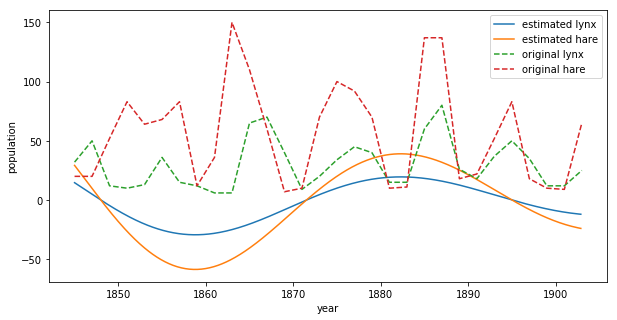

In [9]:
lynx_pred_DMD, hare_pre_DMD  = Q1_interpolated(500)

In [10]:
def Q2_interpolated(num_of_points):
    
    df = pd.read_csv('hwk2data.csv')
    
    t_new, hare_new, lynx_new = interpolate(df, num_of_points)
    
    # time step between interpolated points
    dt = t_new[1] - t_new[0]
    
    # Construct X 
    X = np.array([lynx_new, hare_new])
    
    # Construct Hankel Matrix
    H = hankel(X.T)
    
    # svd H and plot SVD spectro
    [u_h, s_h, v_h] = svd(H, full_matrices=0)
    
    # pick rank based on plot
    var_explained = np.round(s_h**2/np.sum(s_h**2), 3)
    r = len(var_explained[var_explained>0])
    
    X1 = H[:-1].T
    X2 = H[1:].T
    
    # fit data into DMD model and get prediction
    Phi, Lambda, omega, b, Xdmd = time_delayed_DMD(X1, X2, r, dt)
    
    num_tstep = Xdmd.T[0][0::2].shape[0]
    t = np.linspace(1845, 1903, num=num_tstep)
    
    plt.figure(figsize=(10,5))
    plt.plot(t, np.real(Xdmd.T[0][0::2]), label='estimated lynx')
    plt.plot(t, np.real(Xdmd.T[0][1::2]), label='estimated hare')
    plt.plot(df.year, df.lynx, linestyle='dashed', label='original lynx')
    plt.plot(df.year, df.hare, linestyle='dashed', label='original hare')
    plt.legend()
    
    return np.real(Xdmd.T[0][0::2]), np.real(Xdmd.T[0][1::2]), var_explained
    

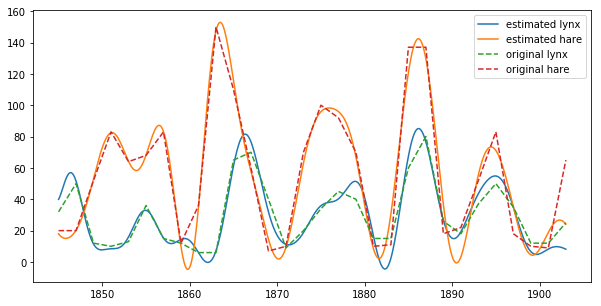

In [11]:
lynx_pred_DMD_TD, hare_pred_DMD_TD, var_explained = Q2_interpolated(500)

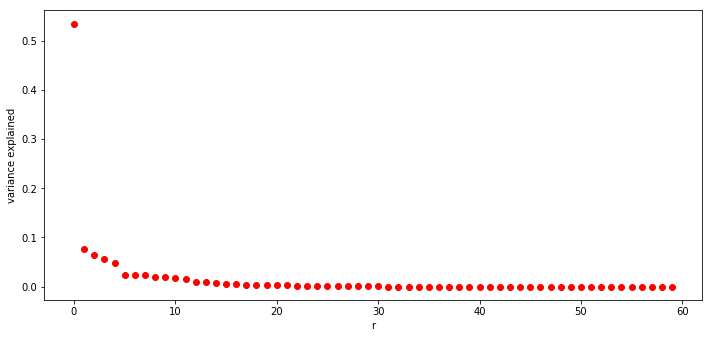

In [12]:
plt.figure(figsize=(10, 5))

ax = plt.subplot(1,1,1)
ax.plot(var_explained[:60], 'ro');
plt.xlabel('r')
plt.ylabel('variance explained')
plt.tight_layout()
plt.subplots_adjust(top=0.92)

## Sparse Identification of Nonlinear Dynamics (SINDy)

In [13]:
def lotkavolterra(t, x0, b, p, d, r):
    x, y = x0
    return [(b-p*y)*x,  (r*x - d) * y]

def construct_derivatives(X, dt):
    """
    Take derivative build Xdot
    """
    X_dot = np.zeros(len(X))

    
    for i in range(len(X) - 1):
        X_dot[i-1] = (X[i+1] - X[i-1]) / (2*dt)

        
    return X_dot

def construct_features(X, Y, term_list):
    """
    Build Library of Candidate Nonlinearities
    """
    features = {}
    
    for term in term_list:
        
        if term not in features.keys():
            features[term] = eval(term)
    
    # return a list of arrays
    return features

def fit_lv(X1, y1, X2, y2, y1_init, y2_init, t):
    """
    This function fit data to lotka-volterra model
    Use Sparse Regression to Find Active Terms
    Parameter:
        X: feature matrix created from SINDy method
        y: x_dot in SINDy method
    """
    clf = linear_model.Lasso(alpha=0.005)
    clf.fit(X1, y1)
    b = np.abs(clf.coef_[0])
    p = np.abs(clf.coef_[1])
    
    clf.fit(X2, y2)
    d = np.abs(clf.coef_[0])
    r = np.abs(clf.coef_[1])
    
    print(b,p,d,r)
    
    lv = solve_ivp(lotkavolterra, t, (y1_init, y2_init), args=(b,p,d,r),dense_output=True)
    
    return lv


In [14]:
def Q3(tstep):
    
    df = pd.read_csv('hwk2data.csv')

    y1_init = df.hare[0]
    y2_init = df.lynx[0]

    t_new, hare_new, lynx_new = interpolate(df, tstep)
    dt = t_new[1] - t_new[0]
    
    xdot = construct_derivatives(hare_new, dt)
    ydot = construct_derivatives(lynx_new, dt)
    
    X = hare_new[1:-1]
    Y = lynx_new[1:-1]
    xdot = xdot[:-2]
    ydot = ydot[:-2]
    
    X_features = construct_features(X, Y, [ "X", "X*Y"])
    AX = np.array([X_features['X'], X_features['X*Y']])

    Y_features = construct_features(X, Y, [ "Y", "X*Y"])
    AY = np.array([Y_features['Y'], Y_features['X*Y']])
    
    t = [0, len(t_new)]
    
    # Nonlinear Model
    lv = fit_lv(AX.T, xdot, AY.T, ydot, hare_new[0], lynx_new[0], t)
    
    t = np.arange(0, len(t_new), 1)
    y_pred = lv.sol(t)
    
    plt.figure(figsize=(10,5))
    plt.plot(t_new, y_pred[0].T, "b--", label="Estimated Hares")
    plt.plot(t_new, y_pred[1].T, "r--", label="Estimated Lynx")
    plt.plot(t_new, hare_new, label="Interpolated Hares")
    plt.plot(t_new, lynx_new, label="Interpolated Lynx")
    plt.xlabel('year')
    plt.ylabel('population')
    plt.legend()
    
    return  y_pred[1].T, y_pred[0].T

In [85]:
def Q4(tstep):
    
    df = pd.read_csv('hwk2data.csv')

    y1_init = df.hare[0]
    y2_init = df.lynx[0]

    t_new, hare_new, lynx_new = interpolate(df, tstep)
    dt = t_new[1] - t_new[0]
    
    xdot = construct_derivatives(hare_new, dt)
    ydot = construct_derivatives(lynx_new, dt)
    
    X = hare_new[1:-1]
    Y = lynx_new[1:-1]
    xdot = xdot[:-2]
    ydot = ydot[:-2]
    
    X_features = construct_features(X, Y, [ "X", "X*Y", 'np.sin(X)', 'X**2'])
    AX = np.array([X_features['X'], X_features['X*Y'], X_features['np.sin(X)'],X_features['X**2']])

    Y_features = construct_features(X, Y, [ "Y", "X*Y", 'np.sin(Y)', 'Y**2'])
    AY = np.array([Y_features['Y'], Y_features['X*Y'], Y_features['np.sin(Y)'],Y_features['Y**2']])
    
    t = [0, len(t_new)]
    
    clf = linear_model.Lasso(alpha=0.005)
    clf.fit(AX.T, xdot)
    a = np.abs(clf.coef_[2])
    b = np.abs(clf.coef_[0])
    
    clf.fit(AY.T, ydot)
    c = np.abs(clf.coef_[2])
    d = np.abs(clf.coef_[0])
    
    return a,b,c,d

In [86]:
a,b,c,d = Q4(500)

In [87]:
def self_defined_model(t, x0, a, b, c, d):
    x, y = x0
    return [a*np.sin(x)+b*x, c*np.sin(y)+d*y]

In [88]:
df = pd.read_csv('hwk2data.csv')

y1_init = df.hare[0]
y2_init = df.lynx[0]

t_new, hare_new, lynx_new = interpolate(df, 500)
dt = t_new[1] - t_new[0]

t = [0, len(t_new)]    

model = solve_ivp(self_defined_model, t, (y1_init, y2_init), args=(a,b,c,d),dense_output=True)

In [89]:
t = np.arange(0, len(t_new), 1)
y_pred = model.sol(t)

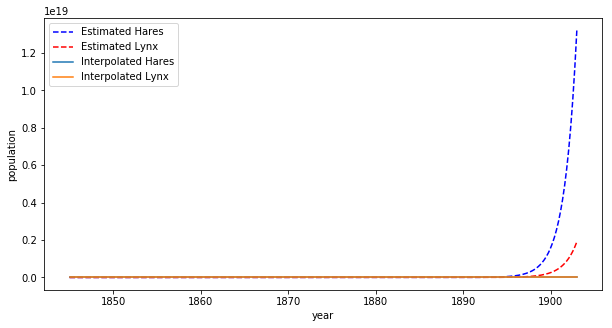

In [92]:
plt.figure(figsize=(10,5))
plt.plot(t_new, y_pred[0], "b--", label="Estimated Hares")
plt.plot(t_new, y_pred[1], "r--", label="Estimated Lynx")
plt.plot(t_new, hare_new, label="Interpolated Hares")
plt.plot(t_new, lynx_new, label="Interpolated Lynx")
plt.xlabel('year')
plt.ylabel('population')
plt.legend()

0.25826868355783855 0.005554672536259425 0.363021245226718 0.0034181565200417474


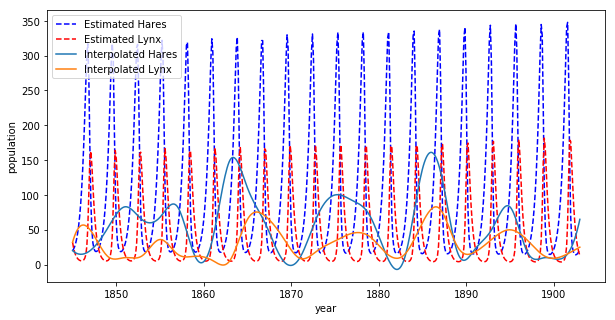

In [15]:
lynx_pred_LV, hare_pred_LV = Q3(500)

In [96]:
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    
    div = p*np.log(np.array(p)/np.array(q))
    div = div[~np.isnan(div)]
    div = np.sum(div)

    return np.round(div, 3)


### 1.lynx_pred_DMD, hare_pre_DMD
### 2.lynx_pred_DMD_TD, hare_pred_DMD_TD
### 3.lynx_pred_LV, hare_pred_LV

In [17]:
lynx_pred_DMD.shape

(499,)

In [18]:
lynx_pred_DMD_TD.shape

(499,)

In [19]:
lynx_pred_LV.shape

(500,)

In [20]:
df = pd.read_csv('hwk2data.csv')
t_new, hare_new, lynx_new = interpolate(df, 500)

In [99]:
kl(lynx_new[:-1], lynx_pred_DMD)

12417.369

In [100]:
kl(lynx_new[:-1], lynx_pred_DMD_TD)

202.831

In [102]:
kl(lynx_new, lynx_pred_LV)

7899.503

In [105]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [107]:
regr = OLS(lynx_pred_LV, add_constant(lynx_new)).fit()
print(regr.bic)
print(regr.aic)

5392.778539182529
5384.349322985685


In [108]:
regr = OLS(lynx_new[:-1], add_constant(lynx_pred_DMD_TD)).fit()
print(regr.bic)
print(regr.aic)

2933.5449406477787
2925.119728456276


In [109]:
regr = OLS(lynx_new[:-1], add_constant(lynx_pred_DMD)).fit()
print(regr.bic)
print(regr.aic)

4378.4981779124255
4370.072965720922


# Part II Belousov-Zhabotinsky chemical oscillator

In [22]:
import h5py

f = h5py.File('BZ.mat','r')
BZ_tensor = f.get('BZ_tensor')
BZ_tensor = np.array(BZ_tensor)

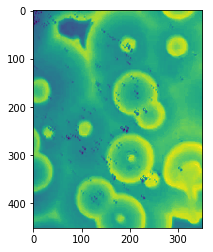

In [23]:
plt.imshow(BZ_tensor[0])

In [24]:
X = []
for frame in BZ_tensor[:100]:
    X.append(frame[50:75,50:75].flatten())
    
X = np.array(X)

In [25]:
X.shape

(100, 625)

In [26]:
#X1 = X[:-1, :]
#X2 = X[1:, :]

In [27]:
#X1 = X1. T

In [28]:
#X2 = X2.T

In [29]:
#Phi, Lambda, omega, b, Xdmd = DMD(X1, X2, 10, 1)

In [30]:
#plt.figure()
#plt.plot(np.real(Xdmd.T[:,157395]))

In [31]:
#Xdmd_img = np.reshape(Xdmd.T, (Xdmd.T[:, 0].shape[0], 451, 351))
#Xdmd_img = np.real(Xdmd_img)

In [32]:
#plt.imshow(Xdmd_img[0])

In [33]:
H = hankel(X.T)
    
# svd H and plot SVD spectro
[u_h, s_h, v_h] = svd(H, full_matrices=0)
    
# pick rank based on plot
var_explained = np.round(s_h**2/np.sum(s_h**2), 3)
r = len(var_explained[var_explained>0])

MemoryError: 

In [ ]:
r